C:\Users\giuli\Desktop\Aquarium\tf_aquarium\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9837 - loss: 0.0967 - val_accuracy: 0.9970 - val_loss: 0.0054
Epoch 2/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9933 - loss: 0.0234 - val_accuracy: 0.9956 - val_loss: 0.0062
Epoch 3/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9941 - loss: 0.0204 - val_accuracy: 0.9950 - val_loss: 0.0074
Epoch 4/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9939 - loss: 0.0191 - val_accuracy: 0.9952 - val_loss: 0.0080
Epoch 5/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9936 - loss: 0.0209 - val_accuracy: 0.9975 - val_loss: 0.0060
Epoch 6/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9939 - loss: 0.0192 - val_accuracy: 0.9941 - val_loss: 0.0091
Epoch 7/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9981 - val_loss: 0.0053
Epoch 8/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9942 -

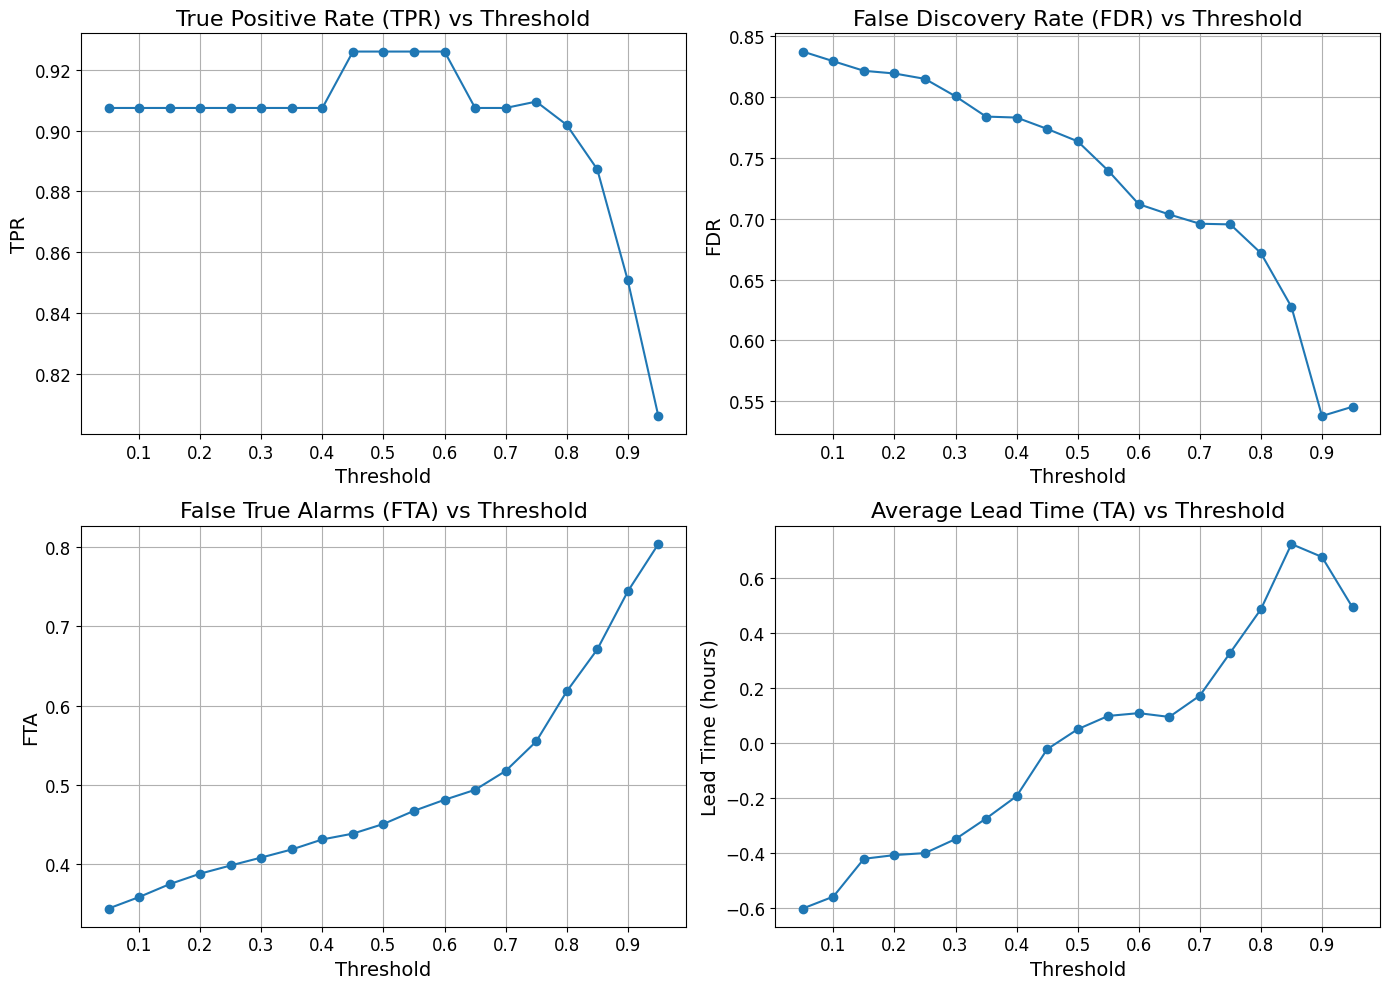

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Funzione per calcolare la media escludendo valori 0 e lead time > 4 ore
def mean_excluding_zeros_and_large_lead_times(values):
    filtered_values = [v for v in values if v != 0 and v <= 4]  # Escludi lead time > 4 ore
    if len(filtered_values) > 0:
        return np.mean(filtered_values)
    else:
        return 0

# Caricamento dei dati sismici e degli eventi vulcanici
seismic_data_path = 'data/final_seismic_signals.pkl'
volcanic_events_path = 'csv_eruzioni/volcanic_events_numeric_controlled.csv'

time_series_df = pd.read_pickle(seismic_data_path)
volcanic_events_df = pd.read_csv(volcanic_events_path)

# Conversione delle colonne 'Starting Time' e 'Ending Time' in formato datetime
volcanic_events_df['Starting Time'] = pd.to_datetime(volcanic_events_df['Starting Time'])
volcanic_events_df['Ending Time'] = pd.to_datetime(volcanic_events_df['Ending Time'])

# Filtraggio degli eventi per l'anno 2021
volcanic_events_2021_df = volcanic_events_df[
    (volcanic_events_df['Starting Time'].dt.year == 2021) &
    (volcanic_events_df['Ending Time'].dt.year == 2021)
]

# Estrazione dei dati sismici per il 2021
time_series_2021_df = time_series_df[time_series_df.index.year == 2021]

# Inizializzazione delle etichette (0 = nessuna eruzione) per tutti i timestamp del 2021
labels_2021 = pd.Series(0, index=time_series_2021_df.index)

# Assegnazione delle etichette di eruzione basate sugli eventi vulcanici
for _, row in volcanic_events_2021_df.iterrows():
    labels_2021[(labels_2021.index >= row['Starting Time']) & (labels_2021.index <= row['Ending Time'])] = 1

# Normalizzazione dei dati
scaler = MinMaxScaler()
normalized_data_2021 = scaler.fit_transform(time_series_2021_df)
normalized_df_2021 = pd.DataFrame(normalized_data_2021, index=time_series_2021_df.index, columns=time_series_2021_df.columns)

# Parametri configurabili
timesteps = 20  # Numero di timesteps precedenti da considerare
future_steps = 1  # Numero di future steps per fare la previsione

# Preparazione dei dati per GRU [samples, timesteps, features]
X, y = [], []
for i in range(timesteps, len(normalized_df_2021) - future_steps):
    X.append(normalized_df_2021.iloc[i-timesteps:i].values)
    y.append(labels_2021.iloc[i + future_steps])
X, y = np.array(X), np.array(y)

# Suddivisione dei dati in training e validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Definizione del modello GRU
model = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Funzione per calcolare le metriche
def calculate_metrics(actual, predicted):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    lead_times = []
    correct_alert_time = 0  # Tempo di allerta corretto
    total_alert_time = 0  # Tempo totale di allerta

    for pred_start, pred_end in predicted:
        pred_start, pred_end = pd.to_datetime(pred_start), pd.to_datetime(pred_end)
        total_alert_time += (pred_end - pred_start).total_seconds()
        
        overlapping_events = actual[
            (actual[:, 0] <= pred_end) & (actual[:, 1] >= pred_start)
        ]

        if len(overlapping_events) > 0:
            true_positives += 1
            lead_time = (pred_start - pd.to_datetime(overlapping_events[0, 0])).total_seconds() / 3600  # lead time in hours
            if lead_time <= 4:  # Considera solo lead time <= 4 ore
                lead_times.append(lead_time)
            
            # Calcola il tempo di allerta corretto
            for act_start, act_end in overlapping_events:
                overlap_start = max(pred_start, act_start)
                overlap_end = min(pred_end, act_end)
                overlap_duration = (overlap_end - overlap_start) / np.timedelta64(1, 's')
                correct_alert_time += overlap_duration
        else:
            false_positives += 1

    for act_start, act_end in actual:
        act_start, act_end = pd.to_datetime(act_start), pd.to_datetime(act_end)
        if not any((pd.to_datetime(pred_start) <= act_end) & (pd.to_datetime(pred_end) >= act_start) for pred_start, pred_end in predicted):
            false_negatives += 1

    TPR = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    FDR = false_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    FTA = (correct_alert_time / total_alert_time) if total_alert_time > 0 else 0
    average_lead_time = np.mean(lead_times) if lead_times else 0

    return TPR, FDR, FTA, average_lead_time

# Inizializza le variabili per accumulare le metriche per ogni soglia
thresholds = np.arange(0.05, 1, 0.05)
metrics = {'Threshold': [], 'TPR': [], 'FDR': [], 'FTA': [], 'Lead Time': []}

# Test del modello su tutti gli anni tranne il 2021
for threshold in thresholds:
    TPRs, FDRs, FTAs, Lead_Times = [], [], [], []

    for year in range(2011, 2023):
        if year == 2021:
            continue

        # Estrai i dati per l'anno corrente
        time_series_year_df = time_series_df[time_series_df.index.year == year]

        # Inizializza le etichette con 0 (nessuna eruzione) per tutti i timestamp dell'anno corrente
        labels_year = pd.Series(0, index=time_series_year_df.index)

        # Filtra gli eventi eruttivi per l'anno corrente
        volcanic_events_year_df = volcanic_events_df[
            (volcanic_events_df['Starting Time'].dt.year == year) &
            (volcanic_events_df['Ending Time'].dt.year == year)
        ]

        # Assegna le etichette per i periodi di eruzione
        for _, row in volcanic_events_year_df.iterrows():
            labels_year[(labels_year.index >= row['Starting Time']) & (labels_year.index <= row['Ending Time'])] = 1

        # Normalizza i dati usando lo stesso scaler addestrato sui dati del 2021
        normalized_data_year = scaler.transform(time_series_year_df)
        normalized_df_year = pd.DataFrame(normalized_data_year, index=time_series_year_df.index, columns=time_series_year_df.columns)

        # Reshape the data to 3D format for GRU [samples, timesteps, features]
        X_year = []
        for i in range(timesteps, len(normalized_df_year) - future_steps):
            X_year.append(normalized_df_year.iloc[i-timesteps:i].values)
        X_year = np.array(X_year)

        # Predici sulle serie temporali dell'anno corrente
        predictions = model.predict(X_year)

        # Assicurati che l'indice temporale corrisponda alla lunghezza delle predizioni
        correct_index = time_series_year_df.index[timesteps:timesteps + len(predictions)]

        # Converti le predizioni in un DataFrame con l'indice corretto
        predictions_df = pd.DataFrame(predictions, columns=['Predicted Eruptions'], index=correct_index)

        # Crea predizioni binarie basate sulla soglia
        binary_predictions = (predictions_df['Predicted Eruptions'] >= threshold).astype(int)

        # Identifica i tempi di inizio e fine delle eruzioni previste
        start_times = []
        end_times = []
        eruption_ongoing = False

        for i in range(len(predictions_df)):
            if binary_predictions.iloc[i] == 1 and not eruption_ongoing:
                start_times.append(predictions_df.index[i])
                eruption_ongoing = True
            elif binary_predictions.iloc[i] == 0 and eruption_ongoing:
                end_times.append(predictions_df.index[i-1])
                eruption_ongoing = False

        if eruption_ongoing:
            end_times.append(predictions_df.index[-1])

        predicted_eruption_times = list(zip(start_times, end_times))

        # Calcola le metriche per l'anno corrente e per la soglia corrente
        actual_eruption_times = volcanic_events_year_df[['Starting Time', 'Ending Time']].values
        TPR, FDR, FTA, avg_lead_time = calculate_metrics(actual_eruption_times, predicted_eruption_times)

        # Accumula le metriche per questo anno
        TPRs.append(TPR)
        FDRs.append(FDR)
        FTAs.append(FTA)
        Lead_Times.append(avg_lead_time)

    # Calcola la media per questo threshold escludendo 0 e lead time > 4 ore
    metrics['Threshold'].append(threshold)
    metrics['TPR'].append(mean_excluding_zeros_and_large_lead_times(TPRs))
    metrics['FDR'].append(mean_excluding_zeros_and_large_lead_times(FDRs))
    metrics['FTA'].append(mean_excluding_zeros_and_large_lead_times(FTAs))
    metrics['Lead Time'].append(mean_excluding_zeros_and_large_lead_times(Lead_Times))

# Converte le metriche in DataFrame per facilitarne la visualizzazione
metrics_df = pd.DataFrame(metrics)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Modifica la dimensione del font per una migliore leggibilità
label_fontsize = 14
title_fontsize = 16
tick_fontsize = 12

# Definisci i tick per l'asse X con un intervallo di 0.05
threshold_ticks = np.arange(0, 1.05, 0.1)

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)  # Applicato a entrambi gli assi
    ax.set_xticks(threshold_ticks)  # Imposta i tick dell'asse X
    ax.grid(True)  # Griglia leggera per migliorare la leggibilità

axs[0, 0].plot(metrics_df['Threshold'], metrics_df['TPR'], marker='o')
axs[0, 0].set_title('True Positive Rate (TPR) vs Threshold', fontsize=title_fontsize)
axs[0, 0].set_xlabel('Threshold', fontsize=label_fontsize)
axs[0, 0].set_ylabel('TPR', fontsize=label_fontsize)

axs[0, 1].plot(metrics_df['Threshold'], metrics_df['FDR'], marker='o')
axs[0, 1].set_title('False Discovery Rate (FDR) vs Threshold', fontsize=title_fontsize)
axs[0, 1].set_xlabel('Threshold', fontsize=label_fontsize)
axs[0, 1].set_ylabel('FDR', fontsize=label_fontsize)

axs[1, 0].plot(metrics_df['Threshold'], metrics_df['FTA'], marker='o')
axs[1, 0].set_title('False True Alarms (FTA) vs Threshold', fontsize=title_fontsize)
axs[1, 0].set_xlabel('Threshold', fontsize=label_fontsize)
axs[1, 0].set_ylabel('FTA', fontsize=label_fontsize)

axs[1, 1].plot(metrics_df['Threshold'], metrics_df['Lead Time'], marker='o')
axs[1, 1].set_title('Average Lead Time (TA) vs Threshold', fontsize=title_fontsize)
axs[1, 1].set_xlabel('Threshold', fontsize=label_fontsize)
axs[1, 1].set_ylabel('Lead Time (hours)', fontsize=label_fontsize)

plt.tight_layout()
plt.show()

# Salva le metriche in un file CSV
metrics_df.to_csv('metrics_threshold_correlation_GRU.csv', index=False)
